# Topic Classification

In [ ]:
!pip install torch=='2.1.0'
!pip install torchtext==0.16.0
!pip install portalocker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## データ準備

- トピック分類のサンプルデータを、RNNで学習できる形に処理する
  - データをロード：torchtext.dataset.AG_NEWSクラス
    - portalockerを事前にインストール
    - ニュース記事のトピック分類のデータ(Worlds,Sports, Business, Sci/Tech)
    - split: 'train' or 'test'
    - イテレータを返す
  - 今回はデータ数を減らすため、split='train'データのみを使用する
- 学習データと検証データに分割する(学習データ10%、検証データ9%)
- それぞれの分の長さの分布等を確認する

In [ ]:
from torchtext import datasets
from sklearn.model_selection import train_test_split

data = datasets.AG_NEWS(split='train')
data = list(data)
train_data, remaining = train_test_split(data, train_size=0.1, random_state=0)
_, val_data = train_test_split(remaining, test_size=0.1, random_state=0)

In [ ]:
# ラベルについて
# 1: "World", 2:"Sports", 3:"Business", 4:"Sci/Tech"
list(data)[:3]

[(3,
  "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."),
 (3,
  'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'),
 (3,
  "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")]

In [ ]:
import pandas as pd
labels = [label for label, text in data]
labels = pd.Series(labels)
labels.value_counts()

,count
3,30000
4,30000
2,30000
1,30000


In [ ]:
# index:0のtext
print(data[0][1])

# 単語のみ抜き出す
print(data[0][1].split())

# 文の長さを確認する
print(len(data[0][1].split()))

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
['Wall', 'St.', 'Bears', 'Claw', 'Back', 'Into', 'the', 'Black', '(Reuters)', 'Reuters', '-', 'Short-sellers,', 'Wall', "Street's", 'dwindling\\band', 'of', 'ultra-cynics,', 'are', 'seeing', 'green', 'again.']
21


<Axes: ylabel='Count'>

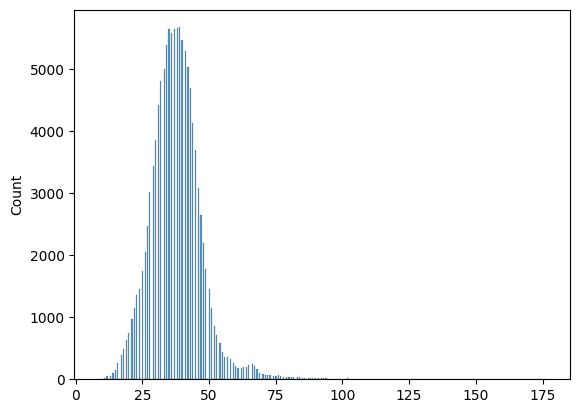

In [ ]:
# 文の長さの分布確認
import seaborn as sns
text_lens = pd.Series([len(text.split()) for _, text in data])
sns.histplot(text_lens)

## データの辞書を作る



1. トークン化
  - 単語(token)に分割する(tokenize)
  - torchtext.data.uHls.get_tokenizerを使用する
  - get_tokenizer(‘basic_english’)
2. イテレータ作成
  - 各単語(token)を返すイテレータを作る
3. 辞書作成
  - torchtext.vacab.build_vocab_from_iteratorを使用する
  - iterator: 単語(token)を返すイテレータ
  - min_freq: 辞書に登録する単語の最小頻度 (デフォルトは1)
  - specials: "unkown"などの特別なtokenを予約する
  - vocab[‘word’]のようにしてその単語のindexを取得する
  - .get_itos() で全tokenのリストを取得する
  - .set_default_index(index)で辞書にない単語のデフォルトのindexを指定する

In [ ]:
# トークン化
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

In [ ]:
# 単語をトークン化できる
tokenizer('I am a student.')

['i', 'am', 'a', 'student', '.']

In [ ]:
# イテレータ作成
def yield_tokens(data):
    for _, text in data:
        yield tokenizer(text)

In [ ]:
next(iter(yield_tokens(data)))

['wall',
 'st',
 '.',
 'bears',
 'claw',
 'back',
 'into',
 'the',
 'black',
 '(',
 'reuters',
 ')',
 'reuters',
 '-',
 'short-sellers',
 ',',
 'wall',
 'street',
 "'",
 's',
 'dwindling\\band',
 'of',
 'ultra-cynics',
 ',',
 'are',
 'seeing',
 'green',
 'again',
 '.']

In [ ]:
# 辞書作成
from torchtext.vocab import build_vocab_from_iterator

# unknownをspcialに追加
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"])
# 辞書にない単語のデフォルトのindexを指定する
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# vocab辞書から'hello'の単語のindexを返す
vocab['hello']

14923

In [ ]:
# 存在しない単語のindexも同様に0
vocab['xxxxxxxxxxx']

0

In [ ]:
# specials=<unk>を指定するとindexは0になる
vocab['<unk>']

0

In [ ]:
# indexから逆引き
vocab.get_itos()[14923]

'hello'

## DataLoaderを作成

- DataLoaderを作成
  - DataLoader: 手元のデータをバッチごとに区切ってイテレーションしてくれるもの
  - バッチサイズ=8
  - Collate_fn: バッチ単位で必要な処理(関数)
    - バッチ単位でpaddingを行う
    - labelを1-4ではなく、0-3に変更する

In [ ]:
train_data[:3]

[(2,
  'SECOND LOOKSnapshots from the latest in college football The boys of Pi Kappa Phi better look out. Mississippi State pulls off the SEC stunner of this Millennium, beating Ron Zook and Florida 38-31.'),
 (1,
  'Summit of French-Speaking Countries Condemns Ivory Coast Leaders at a summit in Burkina Faso of mostly French-speaking nations have condemned authorities in divided Ivory Coast for resuming hostilities in the rebel-held north earlier this month.'),
 (4,
  'Lost faith in Internet Explorer? Try another browser Microsoft has won the browser wars, but a battle is raging for the runner-up spot and one of the contenders has recently been refreshed.')]

In [ ]:
# batch: [(label, text), (label, text),...,]
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  # label, textに対する処理
  label_list = []
  text_list = []
  for label, text in batch:
      # label: 1-4 -> 0~3
      label_list.append(label - 1)
      # tokenize: ["I am a student"] - >["I", "am", "a", "student"] -> (ex.)[4, 1, 6, 7]
      text_list.append(torch.tensor([vocab[token] for token in tokenizer(text)]))

  # padding
  label_list = torch.tensor(label_list)
  text_list = pad_sequence(text_list, batch_first=True, padding_value=0)
  return label_list, text_list

In [ ]:
# 例
label_list, text_list = collate_batch(train_data[:1])
print(label_list)
print(text_list)

tensor([1])
tensor([[  144, 25474,    29,     2,   306,     7,   956,   329,     2,  5780,
             6, 16111, 24933, 27357,   614,   712,    61,     1,  4005,   138,
          4520,   118,     2,  1585, 17035,     6,    50, 11705,     3,  1149,
          2595,  4607,     8,   473, 10331,     1]])


In [ ]:
# 最長の文章は51単語
text_list.shape

torch.Size([1, 36])

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=8, collate_fn=collate_batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, collate_fn=collate_batch, shuffle=False)

In [ ]:
text = "I am a student"
tokenizer(text)

['i', 'am', 'a', 'student']

In [ ]:
# バッチサイズ:8
label, text = next(iter(train_loader))
print(label)
print(text)

tensor([3, 1, 2, 0, 1, 0, 1, 1])
tensor([[ 4495, 12326,   822,  2012,    17, 11742,    12,     9, 15835, 12326,
          8327,     2, 11742,  8327,   484,  3343,    22,  3516,     2,   977,
            49,   734,  5207,     6,     2, 24912, 26449, 27455,     7,  2994,
             3,    20,     6,   381,   188,   220,    40,   279,   231,   734,
         15835, 12326,  3052,    19, 11742,     7,  1266,     3,    47,     6,
           105,  3975,     4,    37,     7,  1194,  1539,  2347,     1],
        [ 7908,  1357, 17089,     4,  1188,     5,  7966, 14612,  3917,     3,
          5075,     1,    54,   672,  2996,  1838,  2290,  6083,  7908, 17089,
             4,  1188,     5,  7966,     8, 14607,    32,  3805,  1819,     3,
           968,    26,    55,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [ 9931,  1115,  4343,  

## word embedding matrixを作成

- gensimのword2vecを使用
  - GoogleNews-vectors-negative300.bin
- tokenのindexに対してword embedding(size=(300,))を返すようなtenrosrを作成する
  - word2vecの戻り値がnumpy arrayであることに注意
- "unk"のベクトルは全word embeddingの平均を取る

In [ ]:
# google drive のマウント
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# gensimのword2vecを使用
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(f'{drive_path}/MyDrive/models/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# 91202語ある
len(vocab)

31918

In [ ]:
import numpy as np

# unkownには，word2vecの全単語の平均のベクトルを適用する
unk_vector = torch.from_numpy(np.mean(word2vec.vectors, axis=0))
embedding_matrix = np.zeros((len(vocab), 300))  # まずベクトルを初期化する

for i, word in enumerate(vocab.get_itos()):
    if word in word2vec:
        embedding_matrix[i] = torch.from_numpy(word2vec[word])  # 初期化したベクトルにvocabの単語のベクトルを代入
    else:
        embedding_matrix[i] = unk_vector  # unkであれば、単語の平均を代入

In [ ]:
# indexが2の単語は"the"
print(vocab.get_itos()[2])

# "the"の300次元のベクトル
print(word2vec[vocab.get_itos()[2]].shape)
# print(word2vec[vocab.get_itos()[2]])

# embedding_matrixのindexにこのベクトルを代入する
embedding_matrix = np.zeros((len(vocab), 300))  # まずベクトルを初期化する
embedding_matrix[2] = torch.from_numpy(word2vec[vocab.get_itos()[2]])

# 初期化したembedding_matrixにtheのベクトルが入っているのがわかる
print(embedding_matrix)

the
(300,)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.08007812  0.10498047  0.04980469 ...  0.00366211  0.04760742
  -0.06884766]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
# unkownには，word2vecの全単語の平均のベクトルを適用する
print(word2vec.vectors.shape)
print(np.mean(word2vec.vectors, axis=0).shape)

(3000000, 300)
(300,)


## トピック分類用のモデルを作成

- トピック分類用のmany-to-oneのRNNを作成する(前セクションの物を転用)
  - embedding層
    - nn.Embedding.from_pretrained()を使用して学習済みのword_embeddingを初期値として使用する(学習可能とする)

In [ ]:
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=None, num_layers=1, rnn_type='LSTM', bidirectional=False):

        super().__init__()
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        # embedding layer追加 (vocab_size x embedding_dim)
        if embedding_matrix is not None:
            # embedding matrixで重みを初期化
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        input_size = embedding_dim

        if rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError('Unsupported RNN type. Choose from ["LSTM", "RNN", "GRU", "UGRNN"]')

        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output_seq, _ = self.rnn(x)
        output_seq = output_seq[:, -1, :]
        # output_seq: [batch_size, seq_len, hidden_size*num_directions]
        out = self.fc(output_seq)
        return out

## トピック分類の学習ループ

In [ ]:
# 学習ループ
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (labels, sentences) in enumerate(train_loader):
            sentences = sentences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(sentences)
            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}")

        # 検証データを使用して検証エラーを計算
        model.eval()
        val_loss = 0
        total_samples = 0
        total_correct = 0
        for labels, sentences in val_loader:
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            # loss計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # accuracy計算
            _, predicted = torch.max(outputs, dim=-1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = total_correct / total_samples
        print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [ ]:
vocab_size = len(vocab)
num_classes = 4
embedding_dim = 300
hidden_size = 64
output_size = num_classes
learning_rate = 0.001
num_epochs = 3
num_layers = 1

# モデル作成
model = Model(vocab_size, embedding_dim, hidden_size, output_size, embedding_matrix=torch.tensor(embedding_matrix),
              num_layers=num_layers, rnn_type='LSTM', bidirectional=True)

# 損失関数とOptimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs)

RuntimeError: Input and parameter tensors are not the same dtype, found input tensor with Double and parameter tensor with Float